device:  cuda


469it [00:07, 60.12it/s]
469it [00:07, 64.08it/s]
469it [00:06, 68.46it/s]
469it [00:07, 65.40it/s]
469it [00:07, 63.43it/s]
469it [00:06, 70.00it/s]
469it [00:07, 63.64it/s]
469it [00:06, 70.15it/s]
469it [00:07, 64.03it/s]
469it [00:07, 63.75it/s]


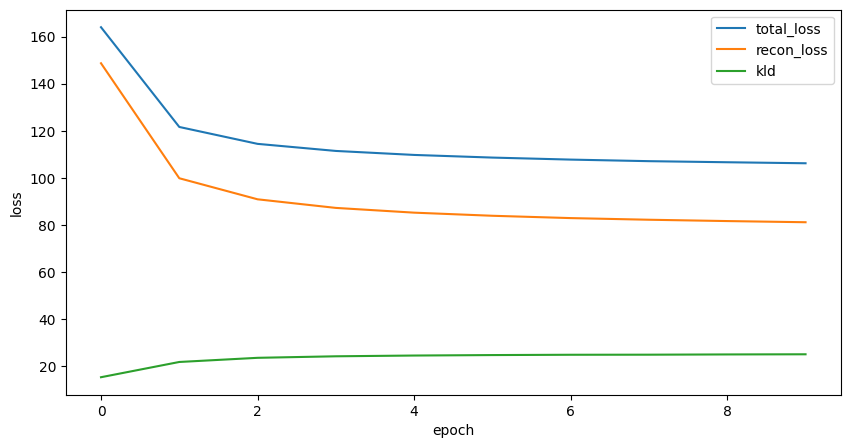

469it [00:06, 69.42it/s]
469it [00:07, 61.64it/s]
469it [00:06, 68.26it/s]
469it [00:07, 63.51it/s]
469it [00:07, 62.83it/s]
469it [00:06, 69.46it/s]
469it [00:07, 63.03it/s]
469it [00:06, 69.35it/s]
469it [00:07, 64.15it/s]
469it [00:07, 66.21it/s]


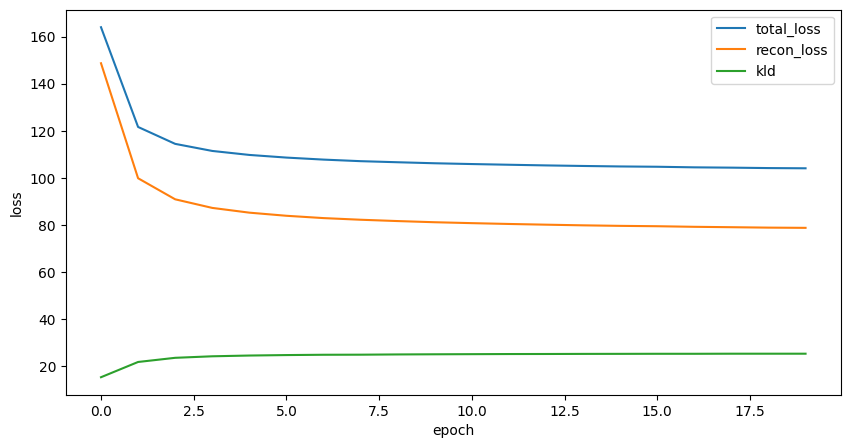

469it [00:07, 65.87it/s]
469it [00:07, 62.02it/s]
469it [00:06, 69.19it/s]
469it [00:07, 62.76it/s]
469it [00:07, 66.08it/s]
469it [00:07, 65.86it/s]
469it [00:07, 63.03it/s]
469it [00:06, 68.98it/s]
469it [00:07, 63.03it/s]
469it [00:07, 66.78it/s]


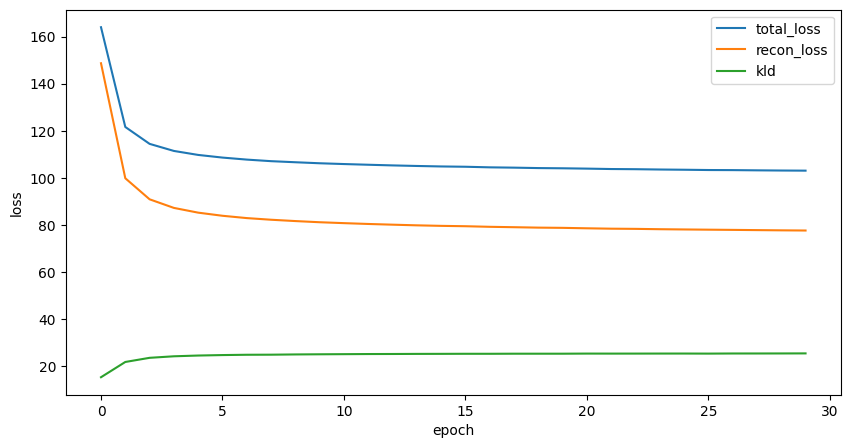

469it [00:07, 65.07it/s]
469it [00:07, 63.25it/s]
469it [00:06, 69.29it/s]
469it [00:07, 62.96it/s]
469it [00:07, 66.12it/s]
469it [00:07, 64.07it/s]
469it [00:07, 62.67it/s]
469it [00:06, 68.71it/s]
469it [00:07, 63.02it/s]
469it [00:06, 67.04it/s]


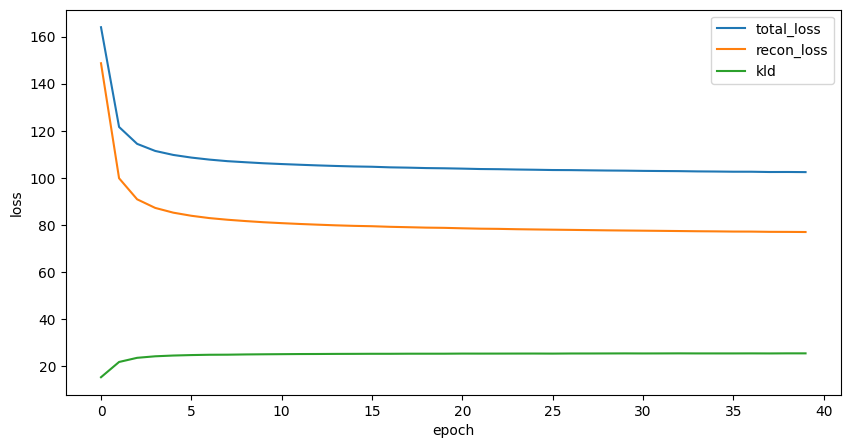

469it [00:07, 62.13it/s]
469it [00:07, 61.93it/s]
469it [00:06, 67.28it/s]
469it [00:07, 62.20it/s]
469it [00:07, 65.97it/s]
469it [00:07, 63.83it/s]
469it [00:07, 61.90it/s]
469it [00:06, 67.85it/s]
469it [00:07, 62.62it/s]
469it [00:07, 66.79it/s]


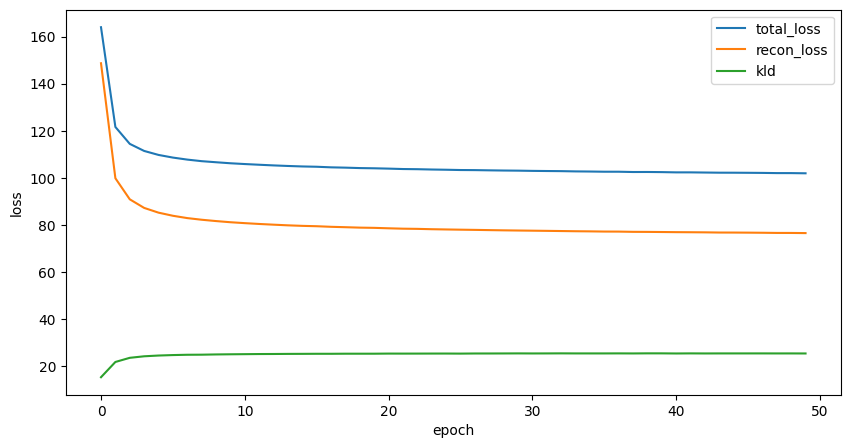

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

tr = transforms.Compose([
    transforms.ToTensor()
])

tr_data = datasets.MNIST(root="./data", train=True, download=True, transform=tr)
te_data = datasets.MNIST(root="./data", train=False, download=True, transform=tr)

train_loader = DataLoader(dataset=tr_data,batch_size=128,shuffle=True)

class enc(nn.Module):
  def __init__(self, inp_size = 784, hid_size = 400, out_size = 20):
    super().__init__()
    self.l1 = nn.Linear(inp_size, hid_size)
    self.ml = nn.Linear(hid_size, out_size)
    self.lvl = nn.Linear(hid_size, out_size)

  def forward(self, x):
    # (bs, 1, 28, 28) --> (bs, 784)
    gg = x.view(x.size(0), -1)
    gg = F.relu(self.l1(gg))
    mean = self.ml(gg)
    lvl = self.lvl(gg)
    return mean, lvl


class vae(nn.Module):
  def __init__(self, inp_size = 784, hid_size = 400, out_size = 20):
    super().__init__()

    self.enc = enc(inp_size, hid_size, out_size)

    self.dec = nn.Sequential(
        nn.Linear(out_size, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, inp_size),
        nn.Sigmoid()
    )

  def reparam(self, mean, lvl):
    std = torch.exp(0.5 * lvl)
    eps = torch.randn_like(std)
    return mean + eps * std

  def forward(self, x):
    mean, lvl = self.enc(x)
    z = self.reparam(mean, lvl)
    recon = self.dec(z)
    recon = recon.view(-1, 1, 28, 28)
    return recon, mean, lvl


def loss_fn(recon, x, mean, lvl):
  bce = F.binary_cross_entropy(recon, x, reduction='sum')
  kld = -0.5 * torch.sum(1 + lvl - mean.pow(2) - lvl.exp())
  return bce + kld, bce, kld

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

inp_size = 784
hid_size = 400
out_size = 20
num_epochs = 50
bs = 128
lr = 1e-3

model = vae(inp_size, hid_size, out_size).to(device)
op = optim.Adam(model.parameters(), lr=lr)

tr_loss = []
bce_loss = []
kld_loss = []


def train(epoch):
  model.train()
  total_loss = 0
  total_bce = 0
  total_kld = 0

  for batch_idx, (x, _) in tqdm(enumerate(train_loader)):
    x = x.to(device)
    op.zero_grad()

    recon_batch, mean, lvl = model(x)

    loss, bce, kld = loss_fn(recon_batch, x, mean, lvl)

    loss.backward()
    op.step()

    total_loss += loss.item()
    total_bce += bce.item()
    total_kld += kld.item()

  avg_loss = total_loss / len(train_loader.dataset)
  avg_bce = total_bce / len(train_loader.dataset)
  avg_kld = total_kld / len(train_loader.dataset)

  return avg_loss, avg_bce, avg_kld


def plot_loss(train_loss, bce_loss, kld_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label = 'total_loss')
    plt.plot(bce_loss, label = 'recon_loss')
    plt.plot(kld_loss, label = 'kld')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


for e in range(1, num_epochs + 1):
    loss, bce, kld = train(e)
    tr_loss.append(loss)
    bce_loss.append(bce)
    kld_loss.append(kld)

    if e % 10 == 0:
        plot_loss(tr_loss, bce_loss, kld_loss)


def vis_recon(model, data):
    with torch.no_grad():
        imgs = data[:8]

        recon, _, _ = model(imgs)

        plt.figure(figsize=(12, 4))
        for i in range(8):
            plt.subplot(2, 8, i+1)
            plt.imshow(imgs[i][0].cpu(), cmap='gray')
            plt.axis('off')

            plt.subplot(2, 8, i+9)
            plt.imshow(recon[i][0].cpu(), cmap='gray')
            plt.axis('off')
        plt.show()

vis_recon(model.to(cpu), next(iter(train_loader))[0])




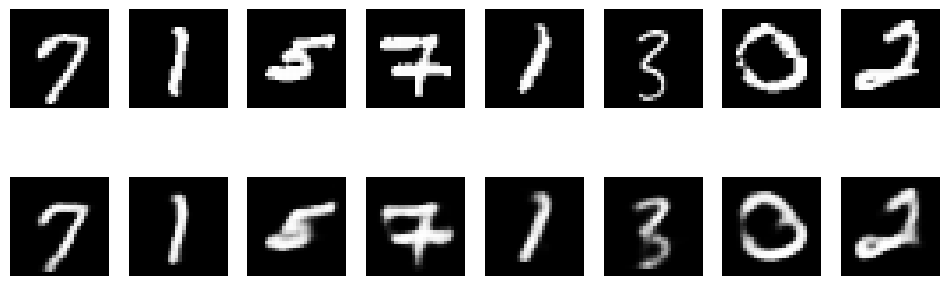

In [6]:
vis_recon(model.to('cpu'), next(iter(train_loader))[0])